## Estimate the activity of a simulated surface

#### Imports

In [18]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys
sys.path.append('../scripts')
from functions import *

#### Simulate HEA surface

In [3]:
# Initialize a surface from a given stochiometry
dim_x, dim_y, split = 100, 100, [0.2 , 0.2 , 0.2 , 0.2 , 0.2 ]

HEA_surface = initialize_surface(dim_x, dim_y, metals, split)

# Predict energies on all sites for both adsorbates + mixed_sites
HEA_surface = precompute_binding_energies_SPEED2(HEA_surface, dim_x, dim_y, models)

#### Estimate activity of each site

In [3]:
# Make a function, that takes a surface in and returns it with a new
# matrix representing the activities on each site

# Decisions based on deltaG I guess
# Go through all indexes (x, y) and check for any negtive H neighb
# binding energies

In [21]:
def per_site_activity_special(COOH_binding_energies, H_binding_energies, eU):
    """This activity estimation function returns the 
    activity per surface atom.
    The activity is estimated based on the COOH binding
    energies (DeltaG), but the COOH energies from sites, 
    where H binds to a neighbour hollow site are not included
    Hence, they will contribute with 0 activity"""

    allowed_energies = [] #All the COOH binding energies on sites, where H is not a neighbouring adsorbate
    disqualified_energies = 0

    for idx_x in range(dim_x):
        for idx_y in range(dim_y):
            # Check if any of the neighbouring hollow sites could house an H
            security_clearence = True
            for x_diff, y_diff in [(0, 0), (-1, 0), (0, -1)]:
                neighbour_H_G = H_binding_energies[idx_x+x_diff, idx_y+y_diff]
                if neighbour_H_G < 0:
                    disqualified_energies += 1
                    security_clearence = False
                    continue
            
            if security_clearence == True:
                # If we get here it means no H + COOH disprop reac
                allowed_energies.append(COOH_binding_energies[idx_x][idx_y])
    
    j_avg = per_site_activity(allowed_energies, eU, jD=1.)
    return j_avg

def per_site_activity(energies, eU, jD=1.):
    """This activity estimation function returns the 
    activity per surface atom.
    The activity is estimated based on the COOH binding
    energies (DeltaG), but the COOH energies from sites, 
    where H binds to a neighbour hollow site
    The highest possible activity is 0.5 because of jD=1.
    Calculated using Angewandte Chemie equations 2-4 
    (doi: 10.1002/anie.202014374). Based on a function 
    Jack wrote in https://seafile.erda.dk/seafile/d/8586692f13/files/?p=%2Fscripts%2F__init__.py"""

    E_opt = -0.17
    energies = np.array(energies)
    energies = energies.flatten()
    n_surface_atoms = dim_x*dim_y

    # Making a list of activities
    jki = np.exp((-np.abs(energies - E_opt) -0.17 - eU) / kBT) # The term in the exponent will be 0 in the most optimal case #TJEK is the minus in the right place?
    
    j_avg = np.sum(1. / (1. / jki + 1./jD)) / n_surface_atoms
    return j_avg

## I need a function, where I just input a stoichiometry and a voltage, and 
# Create surface
# Loop through potentials
# surface = regn deltaG'er ud på ny og inkludér potentialet
# Kør aktivitetsudregnerne

def activity_of_surface(stoichiometry, V_min, V_max, SPEED):
    # Create surface
    HEA_surface = initialize_surface(dim_x, dim_y, metals, stoichiometry)
    HEA_surface = precompute_binding_energies_SPEED2(HEA_surface, dim_x, dim_y, models)

    # Loop through potentials
    potential_range = np.linspace(V_min, V_max, 15) #HERHERHERHERHER
    j_avg_list         = []
    j_avg_special_list = []
    for eU in potential_range:

        # Calculate binding energies based on the potentials also
        COOH_binding_energies = HEA_surface["COOH_G"] - eU
        H_binding_energies    = HEA_surface["H_G"]    + eU

        # Use per_site_activity
        if SPEED == False: 
            j_avg_list.append(per_site_activity(COOH_binding_energies, eU, jD=1.))

        # Use per_site_activity_special
        j_avg_special_list.append(per_site_activity_special(COOH_binding_energies, H_binding_energies, eU))
    
    # Find the highest activity
    # Find the index of the maximum value in j_avg_special_list
    max_index = j_avg_special_list.index(max(j_avg_special_list))

    # Get the corresponding potential from potential_range
    max_potential = potential_range[max_index]
    if SPEED == False:
        activity_dict = {"potential_range": potential_range, "j_avg_list": j_avg_list, "j_avg_special_list": j_avg_special_list, "special_max_j": max(j_avg_special_list), "special_max_eU": max_potential}
    else:
        activity_dict = {"j_avg_special_list": j_avg_special_list, "special_max_j": max(j_avg_special_list), "special_max_eU": max_potential}
        #activity_dict = {"potential_range": potential_range, "j_avg_special_list": j_avg_special_list, "special_max_j": max(j_avg_special_list), "special_max_eU": max_potential}
    return activity_dict

def stoch_to_string(stoichiometry):
    string = ""
    for idx, metal in enumerate(metals):
        string += f"{metal}$_{{{stoichiometry[idx]:.2f}}}$"
    return string

def activity_plot(activity_dict):
    fig, ax = plt.subplots(figsize = (8, 5))
    ax.plot(activity_dict["potential_range"], activity_dict["j_avg_list"],         label = "Activity estimate based on all on-top sites")
    ax.plot(activity_dict["potential_range"], activity_dict["j_avg_special_list"], label = "Activity estimate based on select \nnon-CO-poisoned on-top sites")

    # Set axis labels
    ax.set_xlabel('Potential [V]')
    ax.set_ylabel('Estimated activity per-site')

    # Set y-axis to a logarithmic scale
    #ax.set_yscale('log')
    max_j = activity_dict["special_max_j"]
    ax.text(x=0.1, y=activity_dict["special_max_j"], s=
            "Surface stoichiometry \n"+
            stoch_to_string(stoichiometry) + "\n" +
            f"Maximum activity: {max_j:.1e}")

    ax.legend(loc = "upper right")
    
    fig.show()
    return None

/var/folders/_6/524tslys67zcg0hskf43h2y40000gn/T/ipykernel_28018/1242328981.py:118: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


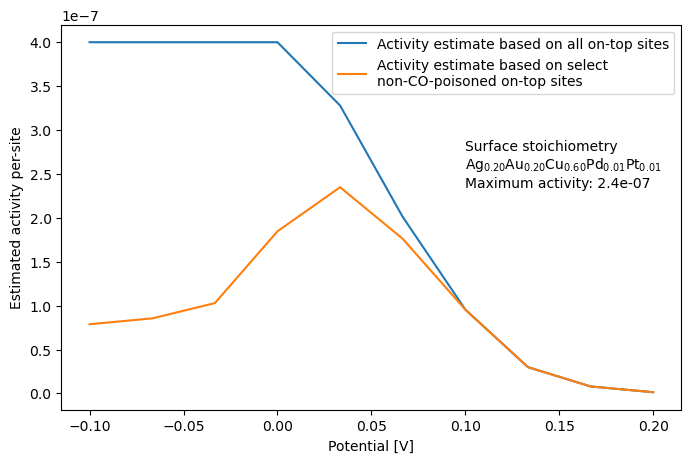

In [46]:
stoichiometry = [0.2, 0.2, 0.2, 0.2, 0.2]
stoichiometry = [0.2, 0.2, 0.599, 0.0, 0.01]
stoichiometry = [0.2, 0.2, 0.598, 0.01, 0.01]


activity_dict = activity_of_surface(stoichiometry, V_min=-0.1, V_max=0.2, SPEED=False)

activity_plot(activity_dict)

/var/folders/_6/524tslys67zcg0hskf43h2y40000gn/T/ipykernel_27805/455433271.py:117: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


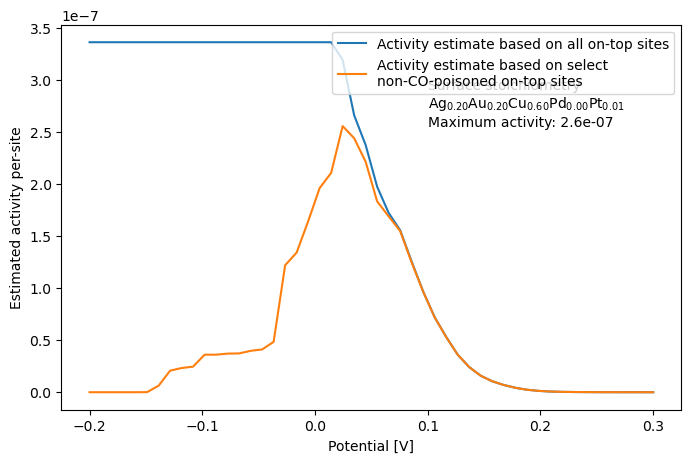

In [10]:
stoichiometry = [0.2, 0.2, 0.4, 0.1, 0.1]
stoichiometry = [0.2, 0.2, 0.599, 0.0, 0.01]

activity_dict = activity_of_surface(stoichiometry, V_min=-0.2, V_max=0.3, SPEED = False)

activity_plot(activity_dict)

/var/folders/_6/524tslys67zcg0hskf43h2y40000gn/T/ipykernel_14182/1583939377.py:114: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


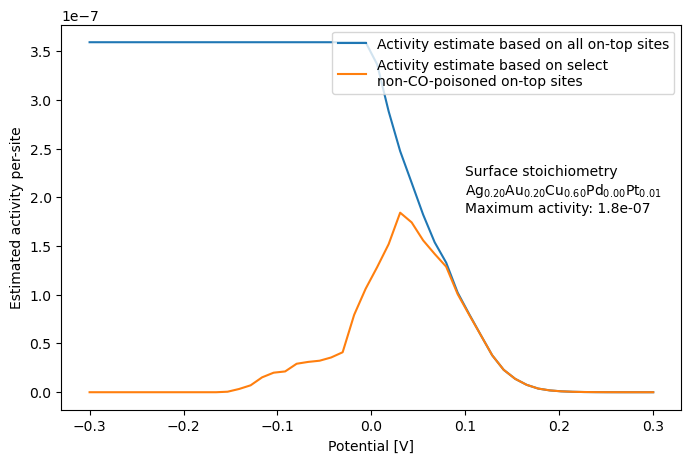

In [144]:
activity_plot(activity_dict)

In [73]:
import scipy
import itertools as it

def count_elements(elements, n_elems):
	count = np.zeros(n_elems, dtype=int)
	for elem in elements:
	    count[elem] += 1
	return count

def get_molar_fractions(step_size, n_elems, total=1., return_number_of_molar_fractions=False):
	'Get all molar fractions with the given step size'
	
	interval = int(total/step_size)
	n_combs = scipy.special.comb(n_elems+interval-1, interval, exact=True)
	
	if return_number_of_molar_fractions:
		return n_combs
		
	counts = np.zeros((n_combs, n_elems), dtype=int)

	for i, comb in enumerate(it.combinations_with_replacement(range(n_elems), interval)):
		counts[i] = count_elements(comb, n_elems)

	return counts*step_size

# Molar fractions with all five metals
molar_fractions_001 = get_molar_fractions(0.01, 5)
molar_fractions_005 = get_molar_fractions(0.05, 5)
molar_fractions_010 = get_molar_fractions(0.10, 5)
molar_fractions_020 = get_molar_fractions(0.20, 5)

# Molar fractions with just three metals - the others at 0
molar_fractions_PtAgAu = get_molar_fractions(0.05, 3)
molar_fractions_PdAgAu = get_molar_fractions(0.05, 3)

# Put in the non-contributing metals
molar_fractions_PtAgAu = np.array([molar_fractions_PtAgAu.T[0], molar_fractions_PtAgAu.T[1], np.zeros(len(molar_fractions_PtAgAu)), np.zeros(len(molar_fractions_PtAgAu)), molar_fractions_PtAgAu.T[2]]).T
molar_fractions_PdAgAu = np.array([molar_fractions_PdAgAu.T[0], molar_fractions_PdAgAu.T[1], np.zeros(len(molar_fractions_PdAgAu)), molar_fractions_PdAgAu.T[2], np.zeros(len(molar_fractions_PdAgAu))]).T

# Ag, Au and Cu at the same probability, Pt and Pd independent # To put 3 metals on one axis, I just need to search for the ones in 005 where a, b, c are equal to eachother
molar_fractions_AgAuCu_PdPt_001 = []

for molar_fraction in molar_fractions_001:
    if molar_fraction[0] == molar_fraction[1] == molar_fraction[2]:
        molar_fractions_AgAuCu_PdPt_001.append(molar_fraction)
molar_fractions_AgAuCu_PdPt_001 = np.array(molar_fractions_AgAuCu_PdPt_001)

In [82]:
len(molar_fractions_AgAuCu_PdPt_001)/1.5/60

19.455555555555556

In [41]:
metals

['Ag', 'Au', 'Cu', 'Pd', 'Pt']

In [22]:
stoichiometry = [0.2, 0.2, 0.599, 0.0, 0.01]

activity_dict = activity_of_surface(stoichiometry, V_min=-0.1, V_max=0.1, SPEED=True)
print(activity_dict["special_max_j"])
print(activity_dict["special_max_eU"])

1.5338591765612364e-07
0.05714285714285716


## Brute-forcing through stoichiometries

In [83]:
estimated_activities = []
estimated_max_eUs = []

for stoichiometry in tqdm(molar_fractions_AgAuCu_PdPt_001):
    activity_dict = activity_of_surface(stoichiometry, V_min=-0.15, V_max=0.2, SPEED=True)
    #print("j: " + str(activity_dict["special_max_j"]))
    #print("max eU: " + str(activity_dict["special_max_eU"]))

    estimated_activities.append(activity_dict["special_max_j"])
    estimated_max_eUs.append(activity_dict["special_max_eU"])

filename = "AgAuCu_PdPt_001_activities.csv"

save_activities_csv(filename, molar_fractions_AgAuCu_PdPt_001, estimated_activities, estimated_max_eUs)

  0%|          | 0/1751 [00:00<?, ?it/s]

Data has been saved to ../Activity_Estimation/AgAuCu_PdPt_001_activities.csv


In [77]:
# Assuming you have three lists: molar_fractions_020, estimated_activities, estimated_max_eUs
def save_activities_csv(filename, molar_fractions, estimated_activities, estimated_max_eUs):
    # Specify the file name
    csv_file_name = "../Activity_Estimation/" + filename
    #filename = "molar_fractions_PtAgAu_activity.csv"

    # Combine the lists into rows
    data = zip(molar_fractions, estimated_activities, estimated_max_eUs)

    # Write to CSV file
    with open(csv_file_name, 'w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)
        
        # Write header if needed
        csv_writer.writerow(['Molar_Fraction', 'Estimated_Activities', 'Estimated_Max_eUs'])
        
        # Write data
        csv_writer.writerows(data)

    print(f'Data has been saved to {csv_file_name}')
    return None


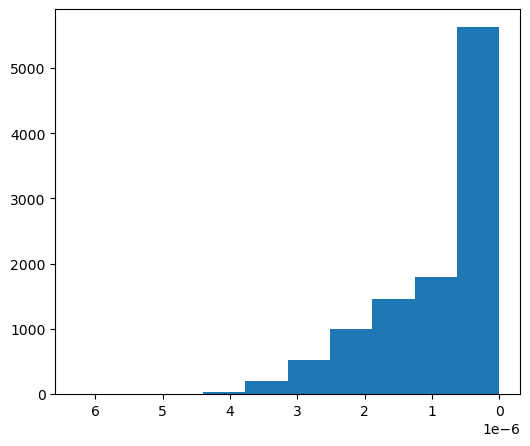

In [34]:
fig, ax = plt.subplots(figsize = (6, 5))
ax.hist(estimated_activities)
#ax.set_xscale('log')
# Invert the x-axis
ax.invert_xaxis()

In [35]:
max(estimated_activities)

6.281907111406326e-06